In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/COMP4211_Colab

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1RRusJqm7Xt1QJlcIE4OP4kkqoum4BW4V/COMP4211_Colab


# **COMP4211 Project**
**Logistic Regression To Predict Heart Disease Prediction**

In [0]:
import os
import sys
import math
import warnings
import pickle
import scipy.special
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
from time import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, Perceptron # Trainin
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, learning_curve, validation_curve, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix, classification_report, mean_squared_error, r2_score # Stopping Metrics
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils.fixes import loguniform
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader  # Preprocessing
from torch.utils.data import random_split
from torch.optim import Adam, SGD # Training
from torch.utils.tensorboard import SummaryWriter  # Stopping Metrics
from torchsummary import summary

## **Data Preprocessing**

In [0]:
data_path = "./Data/framingham.csv"
dfo = pd.read_csv(data_path)
dfo.head(20)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,1.0,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,2.0,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,1.0,0,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1.0,1,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


In [0]:
# Description of data
dfo.describe().round(decimals = 3)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000,4238.000,4133.000,4238.000,4209.000,4185.00,4238.000,4238.000,4238.000,4188.000,4238.000,4238.000,4219.000,4237.000,3850.000,4238.000
mean,0.429,49.585,1.979,0.494,9.003,0.03,0.006,0.311,0.026,236.722,132.352,82.893,25.802,75.879,81.967,0.152
std,0.495,8.572,1.020,0.500,11.920,0.17,0.077,0.463,0.158,44.590,22.038,11.911,4.080,12.027,23.960,0.359
min,0.000,32.000,1.000,0.000,0.000,0.00,0.000,0.000,0.000,107.000,83.500,48.000,15.540,44.000,40.000,0.000
25%,0.000,42.000,1.000,0.000,0.000,0.00,0.000,0.000,0.000,206.000,117.000,75.000,23.070,68.000,71.000,0.000
50%,0.000,49.000,2.000,0.000,0.000,0.00,0.000,0.000,0.000,234.000,128.000,82.000,25.400,75.000,78.000,0.000
75%,1.000,56.000,3.000,1.000,20.000,0.00,0.000,1.000,0.000,263.000,144.000,89.875,28.040,83.000,87.000,0.000
max,1.000,70.000,4.000,1.000,70.000,1.00,1.000,1.000,1.000,696.000,295.000,142.500,56.800,143.000,394.000,1.000


In [0]:
# Correlation between features and labels
cormat = dfo.corr()
np.fill_diagonal(cormat.values, 0)
cormat.round(decimals = 3)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,0.000,-0.029,0.017,0.198,0.318,-0.053,-0.005,0.005,0.016,-0.070,-0.036,0.058,0.082,-0.117,0.006,0.088
age,-0.029,0.000,-0.166,-0.214,-0.193,0.123,0.058,0.307,0.101,0.262,0.394,0.206,0.136,-0.013,0.122,0.225
education,0.017,-0.166,0.000,0.019,0.008,-0.011,-0.035,-0.082,-0.039,-0.023,-0.130,-0.062,-0.138,-0.054,-0.036,-0.054
currentSmoker,0.198,-0.214,0.019,0.000,0.770,-0.049,-0.033,-0.103,-0.044,-0.047,-0.130,-0.108,-0.168,0.062,-0.057,0.019
cigsPerDay,0.318,-0.193,0.008,0.770,0.000,-0.046,-0.033,-0.066,-0.037,-0.026,-0.089,-0.057,-0.093,0.075,-0.059,0.058
BPMeds,-0.053,0.123,-0.011,-0.049,-0.046,0.000,0.117,0.261,0.052,0.081,0.254,0.194,0.101,0.015,0.051,0.087
prevalentStroke,-0.005,0.058,-0.035,-0.033,-0.033,0.117,0.000,0.075,0.007,0.000,0.057,0.045,0.026,-0.018,0.018,0.062
prevalentHyp,0.005,0.307,-0.082,-0.103,-0.066,0.261,0.075,0.000,0.078,0.164,0.697,0.616,0.301,0.147,0.087,0.178
diabetes,0.016,0.101,-0.039,-0.044,-0.037,0.052,0.007,0.078,0.000,0.040,0.111,0.050,0.087,0.049,0.618,0.097
totChol,-0.070,0.262,-0.023,-0.047,-0.026,0.081,0.000,0.164,0.040,0.000,0.209,0.165,0.116,0.091,0.046,0.082


In [0]:
# Find the most correlated features
print(cormat.idxmax())
print(cormat.max())

male                  cigsPerDay
age                        sysBP
education          currentSmoker
currentSmoker         cigsPerDay
cigsPerDay         currentSmoker
BPMeds              prevalentHyp
prevalentStroke           BPMeds
prevalentHyp               sysBP
diabetes                 glucose
totChol                      age
sysBP                      diaBP
diaBP                      sysBP
BMI                        diaBP
heartRate                  sysBP
glucose                 diabetes
TenYearCHD                   age
dtype: object
male               0.317930
age                0.394302
education          0.018532
currentSmoker      0.769690
cigsPerDay         0.769690
BPMeds             0.261187
prevalentStroke    0.117365
prevalentHyp       0.696755
diabetes           0.617627
totChol            0.262131
sysBP              0.784002
diaBP              0.784002
BMI                0.377588
heartRate          0.182246
glucose            0.617627
TenYearCHD         0.225256
dtype: flo

In [0]:
# Find the column with NaN value(True indicate a column with missing value)
# For later preprocessing on the missing data
dfo.isna().any()

male               False
age                False
education           True
currentSmoker      False
cigsPerDay          True
BPMeds              True
prevalentStroke    False
prevalentHyp       False
diabetes           False
totChol             True
sysBP              False
diaBP              False
BMI                 True
heartRate           True
glucose             True
TenYearCHD         False
dtype: bool

In [0]:
# Fill in the missing value with the mean
df = dfo
for i in range(0, len(df.columns) - 1):
  if df.iloc[:, i].isna().any():
    mean = round(df.iloc[:, i].mean())
    df.iloc[:, i] = df.iloc[:, i].fillna(mean)
df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,0.0,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,82.0,0


In [0]:
# Make sure all columns have no NaN value 
df.isna().any() 

male               False
age                False
education          False
currentSmoker      False
cigsPerDay         False
BPMeds             False
prevalentStroke    False
prevalentHyp       False
diabetes           False
totChol            False
sysBP              False
diaBP              False
BMI                False
heartRate          False
glucose            False
TenYearCHD         False
dtype: bool

In [0]:
# Normalization
df.iloc[:, :] = MinMaxScaler().fit_transform(df)
df.round(decimals = 3)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,0.184,1.000,0.0,0.000,0.0,0.0,0.0,0.0,0.149,0.106,0.233,0.277,0.364,0.105,0.0
1,0.0,0.368,0.333,0.0,0.000,0.0,0.0,0.0,0.0,0.243,0.177,0.349,0.320,0.515,0.102,0.0
2,1.0,0.421,0.000,1.0,0.286,0.0,0.0,0.0,0.0,0.234,0.208,0.339,0.238,0.313,0.085,0.0
3,0.0,0.763,0.667,1.0,0.429,0.0,0.0,1.0,0.0,0.200,0.314,0.497,0.316,0.212,0.178,1.0
4,0.0,0.368,0.667,1.0,0.329,0.0,0.0,0.0,0.0,0.302,0.220,0.381,0.183,0.414,0.127,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1.0,0.474,0.000,1.0,0.014,0.0,0.0,1.0,0.0,0.350,0.452,0.466,0.253,0.222,0.130,1.0
4234,1.0,0.500,0.667,1.0,0.614,0.0,0.0,0.0,0.0,0.170,0.203,0.339,0.101,0.212,0.079,0.0
4235,0.0,0.421,0.333,1.0,0.286,0.0,0.0,0.0,0.0,0.239,0.225,0.254,0.157,0.404,0.130,0.0
4236,0.0,0.316,0.000,1.0,0.214,0.0,0.0,0.0,0.0,0.175,0.203,0.413,0.088,0.424,0.119,0.0


In [0]:
# Split the train&valid set and test set
train_valid, test = train_test_split(df, test_size=0.2, random_state = 4211)

In [0]:
# Split the train$valid set to train, valid
train, valid = train_test_split(train_valid, test_size=0.2, random_state = 4211)

In [0]:
# Size of the train valid and test dataframe
print(len(train))
print(len(valid))
print(len(test))

2712
678
848


## **Sklearn Model**

### **Data Split and Cross-Validation**

In [0]:
# Input Label Splitting
train_valid_x = train_valid.iloc[:, 0:len(train.columns)-1]
train_valid_y = train_valid.iloc[:, -1]
train_x = train.iloc[:, 0:len(train.columns)-1]
train_y = train.iloc[:, -1]
valid_x = valid.iloc[:, 0:len(valid.columns)-1]
valid_y = valid.iloc[:, -1]
test_x = test.iloc[:, 0:len(test.columns)-1]
test_y = test.iloc[:, -1]

In [0]:
# Utility function to report best scores
def report(results, n_top=100):
    minsd = 999999
    best = 0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            if (results['std_test_score'][candidate] < minsd and i == 1):
              minsd = results['std_test_score'][candidate]
              best = candidate
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.6f} (std: {1:.6f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
    return results['params'][best]

In [0]:
# Hyperparameter Settings
grid_params = {'hidden_layer_sizes': [(1, )],
               'batch_size': [4, 32, 200],
               'solver': ['sgd', 'adam'],
               'learning_rate': ['constant', 'invscaling', 'adaptive'],
               'learning_rate_init': [0.1, 0.001],
               'activation': ['logistic'],
               'max_iter': [1000],
               'random_state': [4211]}

In [0]:
# Other parameters
device = 'cuda'
save_output = './Output'

In [0]:
# GridSearchCV
sklmodel = MLPClassifier()
sklmodelcv = GridSearchCV(sklmodel, grid_params, cv=5, verbose=3)
start = time()
sklmodelcv.fit(train_valid_x, train_valid_y)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
  % (time() - start, len(sklmodelcv.cv_results_['params'])))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] activation=logistic, batch_size=4, hidden_layer_sizes=(1,), learning_rate=constant, learning_rate_init=0.1, max_iter=1000, random_state=4211, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=logistic, batch_size=4, hidden_layer_sizes=(1,), learning_rate=constant, learning_rate_init=0.1, max_iter=1000, random_state=4211, solver=sgd, score=0.847, total=   2.8s
[CV] activation=logistic, batch_size=4, hidden_layer_sizes=(1,), learning_rate=constant, learning_rate_init=0.1, max_iter=1000, random_state=4211, solver=sgd 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  activation=logistic, batch_size=4, hidden_layer_sizes=(1,), learning_rate=constant, learning_rate_init=0.1, max_iter=1000, random_state=4211, solver=sgd, score=0.848, total=   2.0s
[CV] activation=logistic, batch_size=4, hidden_layer_sizes=(1,), learning_rate=constant, learning_rate_init=0.1, max_iter=1000, random_state=4211, solver=sgd 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


[CV]  activation=logistic, batch_size=4, hidden_layer_sizes=(1,), learning_rate=constant, learning_rate_init=0.1, max_iter=1000, random_state=4211, solver=sgd, score=0.848, total=   2.0s
[CV] activation=logistic, batch_size=4, hidden_layer_sizes=(1,), learning_rate=constant, learning_rate_init=0.1, max_iter=1000, random_state=4211, solver=sgd 
[CV]  activation=logistic, batch_size=4, hidden_layer_sizes=(1,), learning_rate=constant, learning_rate_init=0.1, max_iter=1000, random_state=4211, solver=sgd, score=0.848, total=   2.3s
[CV] activation=logistic, batch_size=4, hidden_layer_sizes=(1,), learning_rate=constant, learning_rate_init=0.1, max_iter=1000, random_state=4211, solver=sgd 
[CV]  activation=logistic, batch_size=4, hidden_layer_sizes=(1,), learning_rate=constant, learning_rate_init=0.1, max_iter=1000, random_state=4211, solver=sgd, score=0.848, total=   1.8s
[CV] activation=logistic, batch_size=4, hidden_layer_sizes=(1,), learning_rate=constant, learning_rate_init=0.1, max_iter

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 10.7min finished


GridSearchCV took 641.68 seconds for 36 candidate parameter settings.


In [0]:
# Output of the model ranks and scores and return the best model params
sklcv_save_path = save_output + '/bestsklcv516.sav'
pickle.dump(sklmodelcv, open(sklcv_save_path, 'wb'))
print(f'Model cv saved to ==> {sklcv_save_path}')

best_skl_params = report(sklmodelcv.cv_results_)
best_skl_params

Model cv saved to ==> ./Output/bestsklcv516.sav
Model with rank: 1
Mean validation score: 0.848083 (std: 0.000933)
Parameters: {'activation': 'logistic', 'batch_size': 32, 'hidden_layer_sizes': (1,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'max_iter': 1000, 'random_state': 4211, 'solver': 'sgd'}

Model with rank: 1
Mean validation score: 0.848083 (std: 0.000933)
Parameters: {'activation': 'logistic', 'batch_size': 200, 'hidden_layer_sizes': (1,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'max_iter': 1000, 'random_state': 4211, 'solver': 'sgd'}

Model with rank: 1
Mean validation score: 0.848083 (std: 0.000933)
Parameters: {'activation': 'logistic', 'batch_size': 200, 'hidden_layer_sizes': (1,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'max_iter': 1000, 'random_state': 4211, 'solver': 'sgd'}

Model with rank: 4
Mean validation score: 0.847788 (std: 0.000590)
Parameters: {'activation': 'logistic', 'batch_size': 4, 'hidden_layer_sizes': (1,), '

{'activation': 'logistic',
 'batch_size': 32,
 'hidden_layer_sizes': (1,),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.1,
 'max_iter': 1000,
 'random_state': 4211,
 'solver': 'sgd'}

### **Model Training**

In [0]:
# Model Training Function
def skltrain(model, inputs, labels, val_inputs, val_labels, save_path):
    start = time()
    model.fit(inputs, labels)
    train_time = time() - start
    pred = model.predict(val_inputs)
    train_loss = model.loss_
    train_acc = accuracy_score(val_labels, pred)
    train_f1 = f1_score(val_labels, pred, average='weighted')
    print('Training time:', train_time)
    print('Loss:', train_loss)
    print('Accuracy:', train_acc)
    print('F1 score:', train_f1)
    print(classification_report(val_labels, pred))

    pickle.dump(model, open(save_path, 'wb'))
    print(f'Model saved to ==> {save_path}')
    print('\n')

In [0]:
# Training with validation set
skl_save_path = save_output + '/bestsklmodel516.sav'
sklmodel = MLPClassifier(**best_skl_params)
print(sklmodel)
skltrain(sklmodel, train_x, train_y, valid_x, valid_y, skl_save_path)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size=32, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1,), learning_rate='adaptive',
              learning_rate_init=0.1, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=4211, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Training time: 1.6305804252624512
Loss: 0.3818790162515369
Accuracy: 0.8480825958702065
F1 score: 0.7783679052280427
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       575
         1.0       0.00      0.00      0.00       103

    accuracy                           0.85       678
   macro avg       0.42      0.50      0.46       678
weighted avg       0.72      0.85      0.78       678

Model saved to ==> ./Output/bestsk

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Load Model for Test Set and Metrics**

In [0]:
# Load the model
skl_load_save_path = save_output + '/bestsklmodel516.sav'
skl_load_model = pickle.load(open(skl_load_save_path, 'rb'))

In [0]:
# Use the loaded model to train with test set
skltrain(skl_load_model, train_valid_x, train_valid_y, test_x, test_y, skl_load_save_path)

Training time: 1.8701131343841553
Loss: 0.38173440159761163
Accuracy: 0.8514150943396226
F1 score: 0.7853861168109704
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       720
         1.0       1.00      0.02      0.03       128

    accuracy                           0.85       848
   macro avg       0.93      0.51      0.48       848
weighted avg       0.87      0.85      0.79       848

Model saved to ==> ./Output/bestsklmodel516.sav




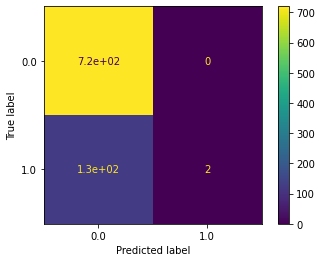

In [0]:
# Confusion Matrix of Test Set
plot_confusion_matrix(skl_load_model, test_x, test_y)

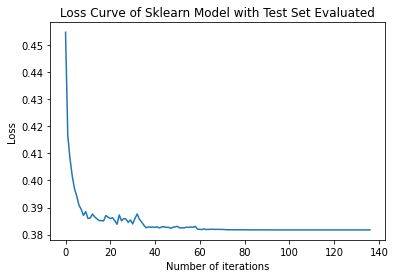

In [0]:
# Plot the loss curve
plt.plot(skl_load_model.loss_curve_)
plt.title('Loss Curve of Sklearn Model with Test Set Evaluated')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.show()

In [0]:
# Weights of each feature for coherance of observation
sklweight = np.append(skl_load_model.coefs_[0].squeeze(), skl_load_model.coefs_[1].squeeze())
sklweightdf = df.iloc[0, :]
sklweightdf.iloc[:] = sklweight
sklweightdf

male              -0.460927
age               -2.768042
education          0.071125
currentSmoker     -0.052116
cigsPerDay        -1.466586
BPMeds            -0.398074
prevalentStroke   -0.662966
prevalentHyp      -0.233244
diabetes          -0.761455
totChol           -0.870188
sysBP             -2.522399
diaBP             -0.333406
BMI               -0.437024
heartRate          0.226464
glucose           -1.190203
TenYearCHD        -4.230272
Name: 0, dtype: float64

## **Pytorch Model**

### **Dataset and Dataloader**

In [0]:
# Custom dataset
class heartDiseaseDataset(Dataset):

    def __init__(self,  csv):
        self.df = csv

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #column 0 to 14 is the feature
        feature = self.df.iloc[idx, 0:15].astype('float').values 
        feature = np.array([feature])
        #column 15 is the target
        label = self.df.iloc[idx, 15]
        label = np.array([label])
        label = np.squeeze(label)
        return feature, label

    def __len__(self):
        return len(self.df)

In [0]:
# Load the data into the dataloader
# Set the num_worker to a lower value and delete the pin_memory = True if you are not on GPU
batch_size = 32
train_set = heartDiseaseDataset(train)
valid_set = heartDiseaseDataset(valid)
test_set = heartDiseaseDataset(test)
train_loader = DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=16,pin_memory=True)

valid_loader = DataLoader(valid_set, batch_size=batch_size,
                          shuffle=True, num_workers=16,pin_memory=True)

test_loader = DataLoader(test_set, batch_size=1,
                         shuffle=True, num_workers=16,pin_memory=True)
# Just a test see whether the dataloader and custom dataset class wordks or not(not related to the model)
dataiter = iter(train_loader)
inputs, labels = dataiter.next()

print(f'Batched features:\n {inputs}, \
      \n Batched labels:\n {labels}')

Batched features:
 tensor([[[0.0000, 0.4474, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.3362, 0.2435, 0.4339, 0.2302, 0.1818, 0.2175]],

        [[0.0000, 0.5000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.1817, 0.2624, 0.4762, 0.3456, 0.2323, 0.1186]],

        [[1.0000, 0.2368, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.1494, 0.2624, 0.4233, 0.2748, 0.4141, 0.0706]],

        [[0.0000, 0.8421, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.3362, 0.2033, 0.2011, 0.2479, 0.2323, 0.0734]],

        [[1.0000, 0.1842, 0.0000, 1.0000, 0.5714, 0.0000, 0.0000, 1.0000,
          0.0000, 0.1834, 0.2931, 0.4709, 0.3105, 0.3131, 0.1525]],

        [[1.0000, 0.5526, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.2479, 0.1489, 0.3492, 0.3042, 0.2626, 0.1243]],

        [[1.0000, 0.6053, 0.0000, 1.0000, 0.0857, 0.0000, 0.0000, 1.0000,
          0.0000, 0.2835, 0.3050, 0.4868, 0.3153,

### **Model Training**

In [0]:
# Save Load function
def save_average(save_path, average_train_loss, average_val_loss, average_train_acc, average_val_acc, average_train_f1, average_val_f1):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'average_train_loss': average_train_loss,
                  'average_val_loss': average_val_loss,
                  'average_train_acc': average_train_acc,
                  'average_val_acc': average_val_acc,
                  'average_train_f1': average_train_f1,
                  'average_val_f1': average_val_f1}
    torch.save(state_dict, save_path)
    print(f'Model average saved to ==> {save_path}')
    
def load_average(save_path):
    try:
        state_dict = torch.load(save_path)
        print(f'Model average loaded from <== {save_path}')
        return state_dict['average_train_loss'], state_dict['average_val_loss'], state_dict['average_train_acc'], state_dict['average_val_acc'], state_dict['average_train_f1'], state_dict['average_val_f1']
    except: # pass anyway
        return [], [], [], [], [], []
    
def save_value(save_path, train_loss, train_acc, train_f1, train_time, validation_loss, validation_acc, validation_f1, validation_time):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'train_loss': train_loss,
                  'train_acc': train_acc,
                  'train_f1': train_f1,
                  'train_time': train_time,
                  'validation_loss': validation_loss,
                  'validation_acc': validation_acc,
                  'validation_f1': validation_f1,
                  'validation_time': validation_time}
    torch.save(state_dict, save_path)
    print(f'Model value saved to ==> {save_path}')
    
def load_value(save_path):
    try:
        state_dict = torch.load(save_path)
        print(f'Model value loaded from <== {save_path}')
        return state_dict['train_loss'], state_dict['train_acc'], state_dict['train_f1'], state_dict['train_time'], state_dict['validation_loss'], state_dict['validation_acc'], state_dict['validation_f1'], state_dict['validation_time']
    except: # pass anyway
        return [], [], [], [], [], [], [], []
    

def save_checkpoint(save_path, model, optimizer, val_loss, latest):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss,
                  'latest': latest,
                  'model': model,
                  'optimizer': optimizer}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')
    
def load_checkpoint(model, optimizer, save_path):
    state_dict = torch.load(save_path)
    
    try:
        model = state_dict['model']
        optimizer = state_dict['optimizer']
    except:
        pass
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    try:
        return val_loss, state_dict['latest'], model, optimizer
    except:
        return val_loss, [], model, optimizer

In [0]:
# Training Function
def TRAIN(net, train_loader, valid_loader,  num_epochs, eval_every, total_step, criterion, optimizer, val_loss, device, save_path):
    
    
    # Other record method
    train_loss = [] # 1 result per batch_size
    train_acc = []
    train_f1 = []
    train_time = []
    validation_loss = []
    validation_acc = []
    validation_f1 = []
    validation_time = []
    avg_train_loss = []   # 1 result per eval_every*batch_size
    avg_train_acc = []
    avg_train_f1 = []
    avg_val_loss = []
    avg_val_acc = []
    avg_val_f1 = []
    save_path2 = save_path + 'v'
    save_path3 = save_path + 'a'
    
    global_step = 0
    if val_loss==None:
        best_val_loss = float("Inf")  
    else: 
        best_val_loss=val_loss
        train_loss, train_acc, train_f1, train_time, validation_loss, validation_acc, validation_f1, validation_time = load_value(save_path2)
        avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, avg_train_f1, avg_val_f1 = load_average(save_path3)
    

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        
        # Initialization
        running_loss = 0.0
        running_corrects = 0
        running_f1 = 0.0
        running_num = 0

        for i, (inputs, labels) in enumerate(train_loader):

            net.train()
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            #print(inputs)

            '''Training of the model'''
            # Forward pass
            starttime = time()
            outputs = net(inputs)
            outputs = outputs.squeeze()
            train_time.append(time() - starttime)
            ##print(outputs)
            
            # Prediction
            threshold = torch.tensor([0.285]).to(device)
            pred = (outputs>threshold).to(device).int()
            pred = pred.squeeze().float()

            # Loss
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            global_step += 1

            # Metrics calculation
            batch_corrects = 0.0
            running_loss += loss.item()
            for i in range(0, len(pred)):
                batch_corrects += torch.equal(pred[i], labels[i])
                running_corrects += torch.equal(pred[i], labels[i])
            running_f1 += f1_score(labels.cpu(), pred.cpu(), average='weighted')
            running_num += len(labels)

            # Other record method
            train_loss.append(loss.item())
            train_acc.append(batch_corrects / len(labels))
            train_f1.append(f1_score(labels.cpu(), pred.cpu(), average='weighted'))

            '''Evaluating the model every x steps'''
            if global_step % eval_every == 0:
                with torch.no_grad():
                    net.eval()
                    val_running_loss = 0.0
                    val_running_corrects = 0
                    val_running_f1 = 0.0
                    val_running_num = 0

                    for val_inputs, val_labels in valid_loader:
                        val_inputs = val_inputs.to(device).float()
                        val_labels = val_labels.to(device).float()

                        # Forward pass
                        val_starttime = time()
                        val_outputs = net(val_inputs)
                        val_outputs = val_outputs.squeeze()
                        validation_time.append(time() - val_starttime)

                        # Prediction
                        threshold = torch.tensor([0.285]).to(device)
                        val_pred= (val_outputs>threshold).to(device).int()
                        val_pred = val_pred.squeeze().float()
                        #print(val_outputs)

                        # Loss
                        val_loss = criterion(val_outputs, val_labels)
                        
                        # Metrics calculation
                        val_batch_corrects = 0.0
                        val_running_loss += val_loss.item()
                        for i in range(0, len(val_pred)):
                            val_batch_corrects += torch.equal(val_pred[i], val_labels[i])
                            val_running_corrects += torch.equal(val_pred[i], val_labels[i])
                        val_running_f1 += f1_score(val_labels.cpu(), val_pred.cpu(), average='weighted')
                        val_running_num += len(val_labels)

                        # Other record method
                        validation_loss.append(val_loss.item())
                        validation_acc.append(val_batch_corrects / len(val_labels))
                        validation_f1.append(f1_score(val_labels.cpu(), val_pred.cpu(), average='weighted'))
                        
                        
                    # Showing the metrics
                    average_train_loss = running_loss / eval_every
                    average_val_loss = val_running_loss / len(valid_loader)
                    average_train_acc = running_corrects / float(running_num)
                    average_val_acc = val_running_corrects / float(val_running_num)
                    average_train_f1 = running_f1 / eval_every
                    average_val_f1 = val_running_f1 / len(valid_loader)

                    # Other record method
                    avg_train_loss.append(average_train_loss)
                    avg_val_loss.append(average_val_loss)
                    avg_train_acc.append(average_train_acc)
                    avg_val_acc.append(average_val_acc)
                    avg_train_f1.append(average_train_f1)
                    avg_val_f1.append(average_val_f1)

                    # ...log the running loss
                    writer.add_scalar(
                        f'training loss {num_epochs}', average_train_loss, global_step)

                    # ...log the running loss
                    writer.add_scalar(
                        f'validation loss {num_epochs}', average_val_loss, global_step)
                    
                    # ...log the running acc
                    writer.add_scalar(
                        f'training accuracy {num_epochs}', average_train_acc, global_step)

                    # ...log the running acc
                    writer.add_scalar(
                        f'validation accuracy {num_epochs}', average_val_acc, global_step)
                    
                    # ...log the running f1
                    writer.add_scalar(
                        f'training f1 {num_epochs}', average_train_f1, global_step)

                    # ...log the running f1
                    writer.add_scalar(
                        f'validation f1 {num_epochs}', average_val_f1, global_step)
                    
                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.6f}, Train Acc: {:.6f}, Train F1: {:.6f}, Valid Loss: {:.6f}, Valid Acc: {:.6f},  Valid F1: {:.6f}'
                          .format(epoch+1, num_epochs, global_step, total_step, average_train_loss,
                                  average_train_acc, average_train_f1, average_val_loss, average_val_acc, average_val_f1))
                    
                    # Reset the metrics for average_mertics
                    running_loss = 0.0
                    running_corrects = 0
                    running_f1 = 0.0
                    running_num = 0 
                    
                    # Record the average
                    save_average(save_path3, avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, avg_train_f1, avg_val_f1)
                    
                    if average_val_loss < best_val_loss:
                        best_val_loss = average_val_loss
                        save_checkpoint(save_path, net, optimizer, best_val_loss, False)
                    
         # Record all value after each epoch
        save_value(save_path2, train_loss, train_acc, train_f1, train_time, validation_loss, validation_acc, validation_f1, validation_time)                
        save_checkpoint(save_path + '_latest', net, optimizer, best_val_loss, True)
                    
    print('Finished Training')

In [0]:
# Model architecture
class LogisticReg(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticReg, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [0]:
# Print model achitecture and total number of parameters
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')

In [0]:
# A test on the output value of the logisticregression network
model = LogisticReg(15,1)
output = model(inputs.float())
output

tensor([[[0.4657]],

        [[0.4616]],

        [[0.5043]],

        [[0.4696]],

        [[0.5274]],

        [[0.5133]],

        [[0.5425]],

        [[0.5470]],

        [[0.4425]],

        [[0.5389]],

        [[0.5309]],

        [[0.5198]],

        [[0.5606]],

        [[0.4697]],

        [[0.4481]],

        [[0.5423]],

        [[0.4821]],

        [[0.4540]],

        [[0.4288]],

        [[0.4952]],

        [[0.4581]],

        [[0.4493]],

        [[0.4393]],

        [[0.5030]],

        [[0.4925]],

        [[0.4974]],

        [[0.4916]],

        [[0.5074]],

        [[0.4623]],

        [[0.4709]],

        [[0.5028]],

        [[0.5341]]], grad_fn=<SigmoidBackward>)

In [0]:
# Showing the parameters
device = 'cuda'
model = LogisticReg(15, 1).to(device)
count_parameters(model)

The model architecture:

 LogisticReg(
  (linear): Linear(in_features=15, out_features=1, bias=True)
)

The model has 16 trainable parameters


In [0]:
# Tensor board [tensorboard --logdir=./runs]
save_output = './Output'
save_path = save_output + '/pytorch_fin_32lr1.pt'
writer = SummaryWriter('project_pytorch')

In [0]:
# Setting of the training model
num_epochs = 10
eval_every = 100
total_step = len(train_loader)*num_epochs
best_val_loss = None
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
model = model.to(device)

TRAIN(model, train_loader, valid_loader, num_epochs, eval_every, total_step, criterion, optimizer, best_val_loss, device, save_path)
writer.close()

Model value saved to ==> ./Output/pytorch_fin_32lr1.ptv
Model saved to ==> ./Output/pytorch_fin_32lr1.pt_latest


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LogisticReg. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch [2/10], Step [100/850], Train Loss: 0.095665, Train Acc: 0.141667, Train F1: 0.005849, Valid Loss: 0.629228, Valid Acc: 0.151917,  Valid F1: 0.044879
Model average saved to ==> ./Output/pytorch_fin_32lr1.pta
Model saved to ==> ./Output/pytorch_fin_32lr1.pt
Model value saved to ==> ./Output/pytorch_fin_32lr1.ptv
Model saved to ==> ./Output/pytorch_fin_32lr1.pt_latest
Epoch [3/10], Step [200/850], Train Loss: 0.166457, Train Acc: 0.146875, Train F1: 0.012579, Valid Loss: 0.544109, Valid Acc: 0.151917,  Valid F1: 0.043199
Model average saved to ==> ./Output/pytorch_fin_32lr1.pta
Model saved to ==> ./Output/pytorch_fin_32lr1.pt
Model value saved to ==> ./Output/pytorch_fin_32lr1.ptv
Model saved to ==> ./Output/pytorch_fin_32lr1.pt_latest
Epoch [4/10], Step [300/850], Train Loss: 0.233795, Train Acc: 0.170139, Train F1: 0.031641, Valid Loss: 0.502339, Valid Acc: 0.169617,  Valid F1: 0.085009
Model average saved to ==> ./Output/pytorch_fin_32lr1.pta
Model saved to ==> ./Output/pytorch_

### **Load Model to Continue Training**

In [0]:
# Load model (value will just be replaced after loading)
device = 'cuda'

load_model = LogisticReg(15, 1).to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.002)
load_save_path = save_output + '/pytorch_fin_32lr2.pt'
load_save_path2 = load_save_path + 'v'
load_save_path3 = load_save_path + 'a'
load_best_val_loss, latest, load_model, load_optimizer = load_checkpoint(load_model, load_optimizer, load_save_path)

Model loaded from <== ./Output/pytorch_fin_32lr2.pt


In [0]:
# Load model to continue training
load_num_epochs = 10
load_eval_every = len(valid_loader)
load_total_step = len(train_loader)*load_num_epochs
load_criterion = nn.BCELoss()
load_model = load_model.to(device)

TRAIN(load_model, train_loader, valid_loader, load_num_epochs, load_eval_every, load_total_step, load_criterion, load_optimizer, load_best_val_loss, device, load_save_path)

Model value loaded from <== ./Output/pytorch_fin_32lr2.ptv
Model average loaded from <== ./Output/pytorch_fin_32lr2.pta
Epoch [1/10], Step [22/850], Train Loss: 0.347804, Train Acc: 0.823864, Train F1: 0.822800, Valid Loss: 0.381039, Valid Acc: 0.808260,  Valid F1: 0.804538
Model average saved to ==> ./Output/pytorch_fin_32lr2.pta
Model saved to ==> ./Output/pytorch_fin_32lr2.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LogisticReg. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch [1/10], Step [44/850], Train Loss: 0.420360, Train Acc: 0.789773, Train F1: 0.782088, Valid Loss: 0.380012, Valid Acc: 0.806785,  Valid F1: 0.808350
Model average saved to ==> ./Output/pytorch_fin_32lr2.pta
Model saved to ==> ./Output/pytorch_fin_32lr2.pt
Epoch [1/10], Step [66/850], Train Loss: 0.421744, Train Acc: 0.815341, Train F1: 0.807158, Valid Loss: 0.413688, Valid Acc: 0.797935,  Valid F1: 0.779952
Model average saved to ==> ./Output/pytorch_fin_32lr2.pta
Model value saved to ==> ./Output/pytorch_fin_32lr2.ptv
Model saved to ==> ./Output/pytorch_fin_32lr2.pt_latest
Epoch [2/10], Step [88/850], Train Loss: 0.060660, Train Acc: 0.770833, Train F1: 0.104406, Valid Loss: 0.379546, Valid Acc: 0.796460,  Valid F1: 0.807681
Model average saved to ==> ./Output/pytorch_fin_32lr2.pta
Model saved to ==> ./Output/pytorch_fin_32lr2.pt
Epoch [2/10], Step [110/850], Train Loss: 0.407056, Train Acc: 0.799716, Train F1: 0.798466, Valid Loss: 0.406755, Valid Acc: 0.794985,  Valid F1: 0.78

### **Metrics**

In [0]:
# Classification Report
def eval(model, test_loader):
    y_test = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            model.eval()
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            outputs = model(inputs)
            threshold = torch.tensor([0.285]).cuda()
            pred = (outputs>threshold).cuda().int()
            y_pred.append(pred.item())
            y_test.append(labels.item())

    print(classification_report(y_test, y_pred))


eval(load_model, test_loader)

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       720
         1.0       0.42      0.25      0.31       128

    accuracy                           0.83       848
   macro avg       0.65      0.59      0.61       848
weighted avg       0.81      0.83      0.82       848



In [0]:
# Retrieve the metrics values
train_loss, train_acc, train_f1, train_time, validation_loss, validation_acc, validation_f1, validation_time = load_value(load_save_path2)
avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, avg_train_f1, avg_val_f1 = load_average(load_save_path3)
# len(train_loss) = roundup(len(train_data) / batch_size) * num_epochs = 2712 / 4 * 10
# len(validation_loss) = roundup(len(validation_data) / batch_size) * [rounddown(roundup(len(train_data) / batch_size) * num_epochs / eval_every)] = 170 * 67
# len(avg_train_loss) = rounddown(roundup(len(train_data) / batch_size) * num_epochs / eval_every) = 67

Model value loaded from <== ./Output/pytorch_fin_32lr2.ptv
Model average loaded from <== ./Output/pytorch_fin_32lr2.pta


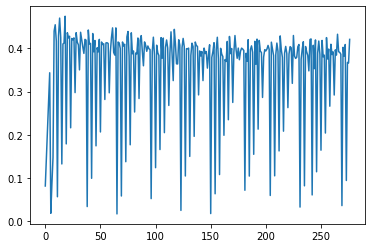

In [0]:
# Visualization of metrics
plt.plot(avg_train_loss)